In [9]:
from pathlib import Path

from fastai.vision.all import load_learner
import numpy as np
from PIL import Image
from IPython.display import display

In [2]:
def add_mask2(source: Image.Image, truth: np.ndarray, pred: np.ndarray) -> Image.Image:
    """
    Given source black and white image, true and predicted mask this function returns image
    with areas colored as following:
    - Green - annotation only
    - Red - prediction only
    - Yellow - overlap
    """
    source = source.convert('RGBA')
    M = np.zeros((*truth.shape, 4), dtype=np.uint8)
    M[:, :, 1] = truth[:, :] * 255
    M[:, :, 0] = pred[:, :] * 255
    M[:, :, 3] = ((truth > 0) | (pred > 0)) * 75
    
    mask = Image.fromarray(M, 'RGBA')
    return Image.alpha_composite(source, mask)

In [3]:
def image2segmentation_path(imgpath: Path) -> Path:
    return Path(str(imgpath).replace("inputs", "segmentations"))

def pixels2area(n: int) -> float:
    """Converts number of pixels into area in um^2"""
    return n * 0.023 * 0.023

def area2mass(A: float) -> float:
    """Converts area in um^2 into mass in mg"""
    return 0.197 * (A ** 1.38)

In [4]:
model = load_learner("models/learner.pkl")  # File models/learner.pkl
model.load("model_resnet34")  # File models/model_resnet34.pth
model.dls.device = 'cpu' 

/opt/conda/envs/copepods/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [5]:
imgs = sorted(list(Path("example_inputs").glob("*.bmp")))
imgs

[Path('example_inputs/20130815 104510 413 000000 0840 0068.bmp'),
 Path('example_inputs/20130815 104513 567 000001 1041 0236.bmp'),
 Path('example_inputs/20130815 104523 141 000001 0656 0816.bmp'),
 Path('example_inputs/20130815 104912 816 000000 1020 0212.bmp'),
 Path('example_inputs/20130815 105037 204 000001 0957 0567.bmp'),
 Path('example_inputs/20130815 143210 522 000000 0628 0604.bmp'),
 Path('example_inputs/20130815 144225 965 000000 0593 0827.bmp'),
 Path('example_inputs/20130902 163400 116 000000 0767 0122.bmp'),
 Path('example_inputs/20130902 163559 808 000000 0181 0802.bmp'),
 Path('example_inputs/20130902 163640 386 000000 0674 0154.bmp'),
 Path('example_inputs/20130902 163759 655 000000 0606 0574.bmp'),
 Path('example_inputs/20130902 164026 563 000001 0454 0218.bmp'),
 Path('example_inputs/20130902 221000 109 000001 0299 0118.bmp'),
 Path('example_inputs/20130902 221205 156 000001 0598 0710.bmp'),
 Path('example_inputs/20130902 221209 454 000004 0994 0674.bmp')]

************************
example_inputs/20130815 104510 413 000000 0840 0068.bmp
Lipid annotation: 0.64923mg
Lipid prediction: 0.8618mg


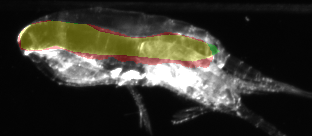

************************
example_inputs/20130815 104513 567 000001 1041 0236.bmp
Lipid annotation: 0.33644mg
Lipid prediction: 0.25098mg


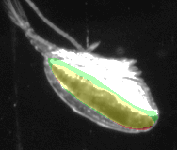

************************
example_inputs/20130815 104523 141 000001 0656 0816.bmp
Lipid annotation: 0.4988mg
Lipid prediction: 0.47262mg


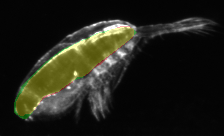

************************
example_inputs/20130815 104912 816 000000 1020 0212.bmp
Lipid annotation: 0.42145mg
Lipid prediction: 0.45242mg


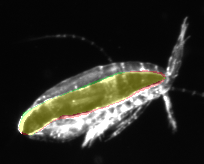

************************
example_inputs/20130815 105037 204 000001 0957 0567.bmp
Lipid annotation: 0.098506mg
Lipid prediction: 0.078894mg


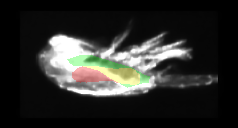

************************
example_inputs/20130815 143210 522 000000 0628 0604.bmp
Lipid annotation: 1.4972mg
Lipid prediction: 1.4696mg


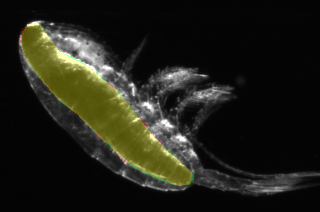

************************
example_inputs/20130815 144225 965 000000 0593 0827.bmp
Lipid annotation: 0.18427mg
Lipid prediction: 0.1714mg


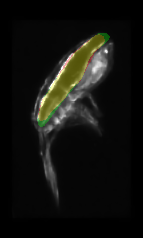

************************
example_inputs/20130902 163400 116 000000 0767 0122.bmp
Lipid annotation: 0.064425mg
Lipid prediction: 0.074129mg


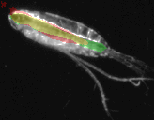

************************
example_inputs/20130902 163559 808 000000 0181 0802.bmp
Lipid annotation: 0.17878mg
Lipid prediction: 0.0063559mg


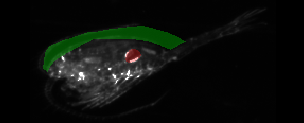

************************
example_inputs/20130902 163640 386 000000 0674 0154.bmp
Lipid annotation: 0.11801mg
Lipid prediction: 0.14993mg


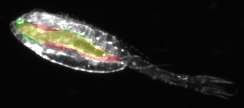

************************
example_inputs/20130902 163759 655 000000 0606 0574.bmp
Lipid annotation: 0.44611mg
Lipid prediction: 0.46604mg


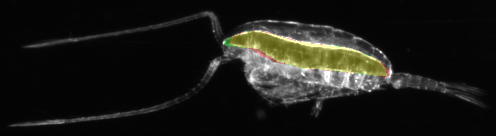

************************
example_inputs/20130902 164026 563 000001 0454 0218.bmp
Lipid annotation: 0.90484mg
Lipid prediction: 0.79982mg


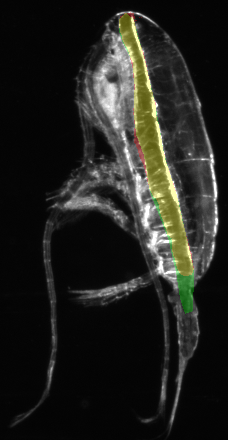

************************
example_inputs/20130902 221000 109 000001 0299 0118.bmp
Lipid annotation: 0.16933mg
Lipid prediction: 1.0766mg


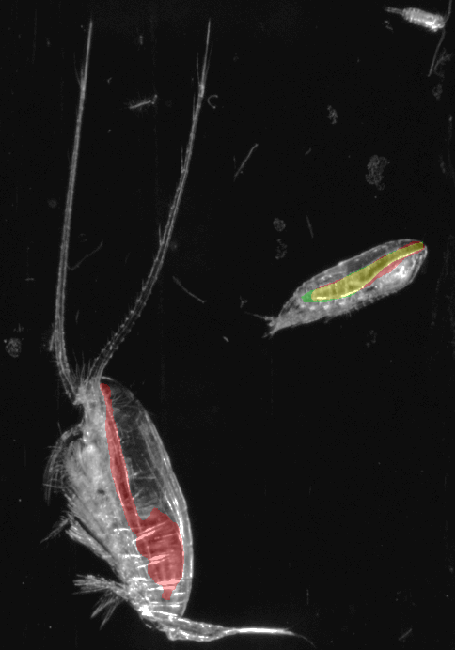

************************
example_inputs/20130902 221205 156 000001 0598 0710.bmp
Lipid annotation: 1.0677mg
Lipid prediction: 0.40364mg


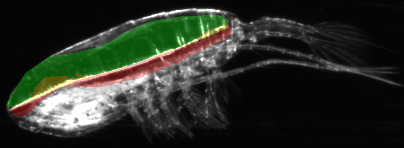

************************
example_inputs/20130902 221209 454 000004 0994 0674.bmp
Lipid annotation: 0.12165mg
Lipid prediction: 0.14317mg


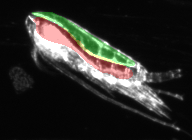

In [10]:
for pimg in imgs:
    im = Image.open(pimg)
    p_segmentation = image2segmentation_path(pimg)

    mask, *_ = model.predict(pimg)
    im_pred_mask = mask.numpy()

    if p_segmentation is not None:
        im_truth = np.array(Image.open(p_segmentation).convert("L"))
    else:
        im_truth = np.zeros_like(im_pred_mask)

    img_with_masks = add_mask2(im, im_truth, im_pred_mask)

    lipid_annotated = area2mass(pixels2area((im_truth > 0).sum()))
    lipid_predicted = area2mass(pixels2area((im_pred_mask > 0.5).sum()))
    print("************************")
    print(pimg)
    print(f"Lipid annotation: {lipid_annotated:.5}mg")
    print(f"Lipid prediction: {lipid_predicted:.5}mg")
    # Green - annotation
    # Red - prediction
    # Yellow - overlap
    display(img_with_masks.convert("RGB"))